In [1]:
from env.env import sogym
from env.utils import FigureRecorderCallback
import numpy as np
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO


/Users/thomasrochefort/opt/anaconda3/envs/sb3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
### Environment test and visualization:

In [2]:
# Let's test the environment using the check_env util from SB3:
env=sogym()
check_env(sogym())

Volume: 30.564 %
Reward: 0


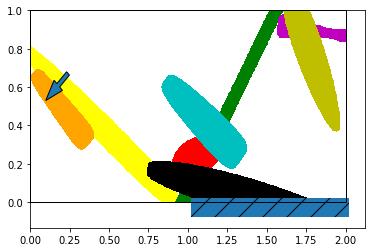

In [3]:
# We can test/visualize the environment using random actions:
obs=env.reset()
done=False
while done==False:
    action=env.action_space.sample()
    obs,reward,done,info=env.step(action)
print("Volume:", np.round(env.volume*100,3),"%")
print("Reward:", np.round(reward,3))
env.plot(test=None)

---
### Multiprocessing

In [4]:
num_cpu = 8 # Number of processes to use
env= make_vec_env(lambda:env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env=VecNormalize(env,gamma=1.0,norm_obs=False)

--- 
### Defining the model

In [5]:
model = PPO("MultiInputPolicy",
            env,
            seed=42,
            n_steps=32,
            batch_size=32,
            verbose=0,
            gamma=1.0,
            tensorboard_log="tb_logs")

--- 
### Training

In [6]:
model.learn(4096*4,
            callback=FigureRecorderCallback(check_freq=8*32),
            tb_log_name='PPO_test')
model.save('model_saved',)
env.save('env_saved.pkl')

---
### Let's visualize the agent's performance:

In [7]:
env=sogym()
env = make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)
env.training=False
env.norm_reward=False

model=model.load('model_saved')
model.set_env(env)

Reward: 0
Volume: 56.8 %


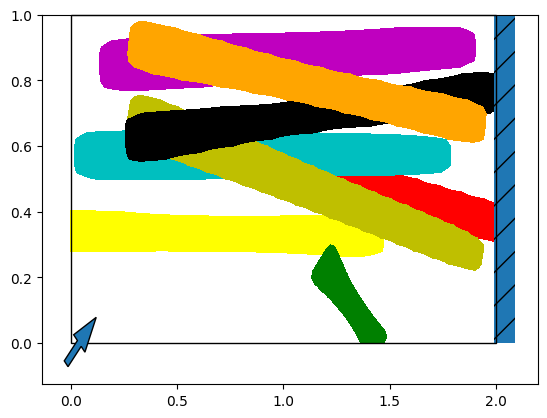

In [18]:
obs=env.reset()
dones=False
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    obs, rewards, dones, info = env.step(np.tanh(action))
print("Reward:",rewards[0])
print("Volume:",np.round(env.get_attr('volume')[0]*100,2),"%")
fig=env.env_method('plot')[0]
fig